In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# t-SNE Python Implementation and Short Explanation 
by Zhonghan Deng <br>
July, 20, 2021

If you have not read the original paper, here is the link. <br>
It will help you to understand the basic or the math behind t-SNE algorithm <br>
https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf <br>
I have read a lot of posts/article/blogs regarding on t-SNE. I feel like the original papre is the bset one. <br>
The reason I did not read the paper at the very beginning is I thought the paper might be hard to read <br>
But this is not the case for this paper. It is not difficult to understand. <br>
**Note: the equations are coming from the above paper and this notebook is only for personal study.** <br> 
----

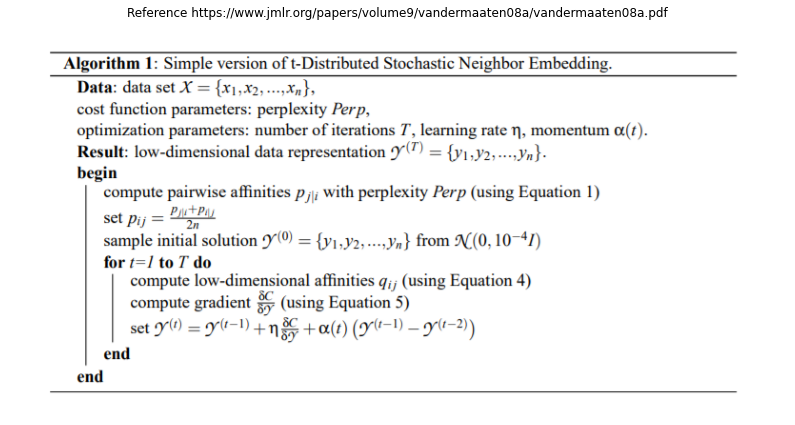

In [2]:
plt.figure(figsize = (14,8))
img = mpimg.imread('tsne.png')
plt.title('Reference https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

# High Dimension Space Calculation

$\Large p_{j|i} = \frac{exp(-||x_i - x_j||^2 / 2\sigma^2)}{\sum_{k \neq i} exp(-||x_i - x_k||^2 / 2\sigma^2)}$	**(Equation 1)** <br>
$p_{j|i}\rightarrow$ center at $x_i$, the probability of picking $x_j$ as its neighbor <br>
## Step 1 
Let us define a function for the negative [squared eucliden distance](https://en.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance) <br>
$-||x_i - x_j||^2$ <br>


In [3]:
def neg_sqaured_euclidean_distance(X):
    """
    Input: matrix of X (n X d) (n: the number of samle, d: number of the feature)
    Output: distance matrix D (n X n) 
    D[i ,j] -> neg_sqaured_euclidean_distance of row i (X_i) and row j (X_j) in X
    Reference: https://stackoverflow.com/a/37040451/11972188 (Dont understand the math?)
    """
    r = np.sum(X**2, 1).reshape(-1, 1)
    D = r - 2 * X.dot(X.T) + r.T
    return -D

In [4]:
test_ed = np.array([[1, 1], [2, 2], [3, 3]])
test_ed

array([[1, 1],
       [2, 2],
       [3, 3]])

In [5]:
D = neg_sqaured_euclidean_distance(test_ed)
D

array([[ 0, -2, -8],
       [-2,  0, -2],
       [-8, -2,  0]])

## Step 2 
Divide by 2 sigma square <br>
$-||x_i - x_j||^2 / 2\sigma^2$ <br>
For each $x_i$, there is a gaussian distribution centered at $x_i$. The variance is sigma

In [6]:
def distance_matrix_by_sigma_square(D, sigma):
    """
    D: distance matrix
    sigma: sigma will be a n length vector. sigma[i] is the variance for the ith row
    """
    # we want sigma to be column vector
    sigma = np.array(sigma).reshape(-1,1) 
    two_sigma_square = 2 * sigma ** 2
    return D / two_sigma_square

## Step 3
Apply the softmax function
$\frac{exp()}{\sum exp()}$ <br>
1. Apply exp function on input matrix
2. Apply sum on input matrix column wise <br>

Note: take care of the numerical stability

In [7]:
def softmax(X, zero_index):
    """
    Compute softmax values for each row of matrix X
    """
    # Normalize the data
    e_x = np.exp(X - np.max(X, axis = 1).reshape([-1, 1]))
    # We want the diagonal to be 0
    if zero_index == None:
        np.fill_diagonal(e_x, 0.)
    else:
        e_x[:, zero_index] = 0.
    # Add a constant to keep numerical stability for log softmax
    c = 1e-5
    e_x = e_x + c
    return e_x / e_x.sum(axis = 1).reshape([-1, 1])

## Step 4
Wrap up step 2 - step 3

In [8]:
def p_prob_matrix(D, sigma, zero_index):
    '''
    D: distance matrix
    sigma: sigma will be a n length vector. sigma[i] is the variance for the ith row
    ---
    return: probability matrix for p (high-dimensional) p[i,j] => Pj|i
    '''
    # step 2
    D_two_sigma_square = distance_matrix_by_sigma_square(D, sigma)
    # step 3
    return softmax(D_two_sigma_square, zero_index = zero_index)

## Step 5
Now we are going to talk about **Perplexity**. We made up sigma in step 2 to test the function. But sigmas are determined by perplexity. t-SNE perfroms a binary search for sigmas that will produce $p_i$ with a fixed perplexity which is defined by the user. (Refer to the [original paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)) <br>

Equations: <br>
$Perp(P_i) = 2^{H(P_i)}$ <br>
$H(P_i) = -\sum_{j}p_{j|i}\log_2{p_{j|i}}$

In [9]:
def perplexity_calc(p):
    """
    p: probability matrix for p
    """
    H_p = -np.sum(p * np.log2(p), axis = 1) # From the equation, apply sum over j which is the column wise direction
    return 2**H_p

## Step 6
Create a binary search function to find the optimal sigma for each row

In [10]:
def binary_search(row, target, zero_index, left = 1e-20, right = 1000., max_i = 10000, tol = 1e-10):
    """
    row: ith row of distance matrix
    left: lower bound of the range
    right: upper bound of the range
    max_i: maximum iteration
    tol: if val smaller or equal to tol, we will stop
    ---
    return: the optimal sigma for this row
    """
    for i in range(max_i):
        mid = (right + left) / 2.
        # the corresponding probability matrix
        prob_matrix_mid = p_prob_matrix(row, mid, zero_index)
        # the corresponding perplexity val
        perp_val = perplexity_calc(prob_matrix_mid)
        if perp_val > target:
            right = mid
        else:
            left = mid
        if np.abs(perp_val - target) <= tol:
            break
    return mid

## Step 7
Create a function to find all the sigmas

In [11]:
def find_sigma(distance_matrix, target_perplexity):
    """
    distance_matrix: n by n matrix which we got from step 1
    target_perplexity: parameter which is defined by user
    ---
    return: an array of optimal sigma for each row, sigma[i] -> optimal sigma for ith row
    """
    sigma = []
    for i in range(distance_matrix.shape[0]):
        # here we find optimal sigma for current row
        optimal_sigma_i = binary_search(distance_matrix[i:i+1, :], target_perplexity, i)
        sigma.append(optimal_sigma_i)
    return np.array(sigma)

## Step 8
The author defines the joint probabilities (Page 6) <br>
$\large P_{ij} = \frac{P_{j|i} + P_{i|j}}{2n}$
Now we wrap up all above steps into one function which take a X, return joint probability <br>
After this step, we are pretty much done with all the steps in high dimensional.

In [12]:
def x_to_p(X, perplexity):
    """
    X: matrix of X (n X d) (n: the number of samle, d: number of the feature)
    ---
    return: joint probability matrix
    """
    # step 1
    distance = neg_sqaured_euclidean_distance(X)
    # step 7
    sigma = find_sigma(distance, perplexity)
    # step 4
    p = p_prob_matrix(distance, sigma, zero_index = None)
    # step 8
    return (p + p.T) / (2. * p.shape[0])

# Low Dimension Calculation

## Step 9
Now let us create a function for q joint probability <br>
$\large q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k}\sum_{k \neq i}(1 + ||y_k - y_l||^2)^{-1}}$ **(Equation 4)**

In [13]:
def q_joint(Y):
    """
    Y: low dimensional representations
    ---
    return: joint probabilities for lower dimension q_ij (n by n matrix)
    """
    # here we use non negative squared euclidean distance
    numerator = 1 / (1 + (-neg_sqaured_euclidean_distance(Y)))
    # diagonal to be zero
    np.fill_diagonal(numerator, 0.)
    # sum over the entire matrix
    denominator = np.sum(numerator)
    return numerator / denominator, numerator

# Gradient Calculation

## Step 10
Now let us create a function for gradient <br>
$\large\frac {\partial C}{\partial y_i} = 4\sum_j(p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

In [14]:
def gradient(p, q, y, q_numerator):
    """
    p: joint probability matrix p
    q: joint probability matrix q
    y: lower dimensional representations
    y_numerator: the distance matrix from step 9
    """
    # you just inset a 'None' at the axis you want to add
    pq_diff = (p - q)[:, :, None] # n*n*1
    y_diff = y[:, None, :] - y[None,:, :] # n*n*2
    q_num_expand = q_numerator[:, :, None] # n*n*1
    grad = np.sum(4. * pq_diff * y_diff * q_num_expand, 1) # n*2
    return grad

# t-SNE Train

## Step 11
Now we can create the train function <br>

In [15]:
def train(X, y, p, num_iterations, learning_rate):
    Y = np.random.normal(0., 0.0001, [X.shape[0], 2])
    P = np.maximum(p, 1e-12)
    for i in range(num_iterations):
        q, q_num = q_joint(Y)
        q = np.maximum(q, 1e-12)
        if (i + 1) % 50 == 0:
            cost = np.sum(p * np.log(p/q))
            print(f'Iteration {i}: error is {cost}')
        grad = gradient(p, q, Y, q_num)
        Y = Y - learning_rate * grad 
    return Y

# Step 12
t-SNE is better used after PCA <br>
Now we implement our main() function

In [16]:
from sklearn.decomposition import PCA
# global variable
perplexity = 20
num_iters = 1000
learning_rate = 50.

def main(X, y, perplexity, num_iters, learning_rate):
    p = x_to_p(X, perplexity)
    X_low = train(X, y, p, num_iters, learning_rate)
    sns.scatterplot(x = X_low[:, 0], y = X_low[:, 1], hue = y)

Iteration 49: error is 0.5196723610827332
Iteration 99: error is 0.40643098073074846
Iteration 149: error is 0.36033260580259174
Iteration 199: error is 0.33291673772505365
Iteration 249: error is 0.3143624158549027
Iteration 299: error is 0.3008652835196855
Iteration 349: error is 0.29041666708754055
Iteration 399: error is 0.28187383924886966
Iteration 449: error is 0.27461025946153106
Iteration 499: error is 0.2682667910611338
Iteration 549: error is 0.26262315653513824
Iteration 599: error is 0.2575364970589316
Iteration 649: error is 0.25291056396572376
Iteration 699: error is 0.24867861014995413
Iteration 749: error is 0.24479244131514258
Iteration 799: error is 0.2412148662897867
Iteration 849: error is 0.23791530099967728
Iteration 899: error is 0.23486831128159733
Iteration 949: error is 0.23205372206936392
Iteration 999: error is 0.22945654910668617


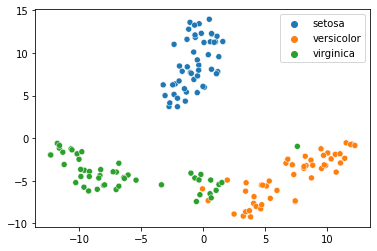

In [17]:
iris = sns.load_dataset('iris')
X = np.array(iris.iloc[:, :-1])
y = np.array(iris.iloc[:, -1])
main(X, y, perplexity, num_iters, learning_rate)

## End 